# Testing bias metrics and mitigation algorithms on a Synthetic dataset

The goal of this analysis is to make a comparison of different bias mitigation methods for classification problems on different types of dataset and to see how these methods impact on different fairness metrics and on the accuracy of the classifier. The datasets on which we will test the fairness algorithms are:

1. Unbias dataset
2. Bias unbalanced dataset
3. Bias balanced dataset

In [1]:
# import libraries
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from Sampler import Sampler
from utility import *
import os

path = 'imgs/synthetic'

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the target variable at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the target variable $y$ are changed s.t. the mean of the $y$ distribution is the mean between the mean of $y$ distribution for the privileged and unprivileged groups. 
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier. 

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

## Dataset creation

Here we will create a binary labeled dataset with 10.000 samples and 11 features of which 4 are informative features and one will act as sensitive attribute:

In [2]:
data = pd.read_csv('synthetic/synthetic.csv')
data

,0,1,2,3,4,5,6,7,8,9,10,s
0,1.117819,2.978286,0.446270,1.462078,-0.603682,-1.010214,-0.850477,-0.534090,2.619979,2.847635,1.0,0
1,-1.241114,0.966580,2.522553,2.197615,-2.049246,-2.272453,-0.912986,-1.074081,0.156897,-0.893949,0.0,0
2,1.499456,3.462662,-1.581721,-0.717028,0.706507,0.067985,1.081010,-1.360287,2.342430,2.600052,1.0,1
3,1.119152,-1.030551,2.154243,-1.041053,0.374413,-1.707872,1.508272,0.426323,-1.545117,-1.741156,0.0,0
4,0.951065,3.900728,0.127303,-0.075893,0.416828,-1.444766,-0.093549,-2.440322,2.097760,1.317815,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.254664,-0.585287,3.564289,-0.540535,-1.765657,0.333707,-1.830294,-1.157792,4.047647,0.873255,0.0,0
9996,-0.235269,1.753106,-1.981381,-0.916348,-0.086612,-2.525506,-0.388470,0.550074,-4.543743,-1.528656,1.0,1
9997,-0.110675,3.144627,-0.940214,0.213754,0.564466,-0.832604,0.367032,-1.312953,1.141139,1.463263,1.0,0
9998,-0.072732,3.316492,-1.425743,-0.717678,0.543238,0.899736,0.086791,-2.040534,3.629779,2.835108,1.0,0


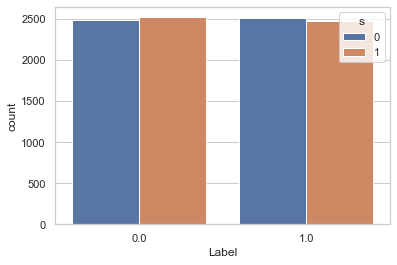

In [3]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.savefig('imgs/synt_unb.pdf')
plt.show()

The dataset seems to be fair with respect to the sensitive attribute

In [4]:
unprivileged_group = [{'s': 0}]
privileged_group = [{'s': 1}]

# Unbias dataset

Here we will apply the metrics and the algorithms defined above on the unbias version of the dataset and compare how these bias mitigation algorithms change the different metrics.

## Bias metrics

Here we train and test a _Logistic Regression_ classifier:

### Dataset Metrics:

Disparate Impact: 1.0162
Statistical Parity: 0.0080




### Classification Metrics:

Balanced accuracy: 0.7621
Statistical parity: 0.0181
Disparate impact: 1.0362
Average odds: 0.0135
Equal opportunity: 0.0167
Theil index: 0.1489


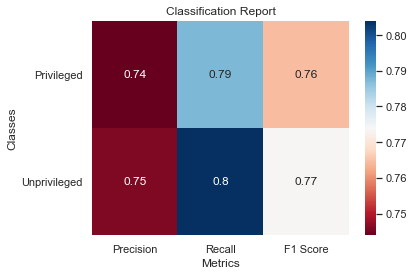

In [5]:
bin_data = BinaryLabelDataset(df=data, protected_attribute_names=['s'], label_names=['10'])

class_metrics = classify(
    make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight='balanced', solver='liblinear')),
    bin_data, privileged_group, unprivileged_group)

From the values of the metrics we can see that the classifier is fair and quite accurate. Let's now test the same metrics on a bias dataset.

## Reweighing

Here we apply the _Reweighing_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [6]:
rw_unbias_data = bin_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7632
Statistical parity: 0.0082
Disparate impact: 1.0179
Average odds: 0.0038
Equal opportunity: 0.0061
Theil index: 0.1479


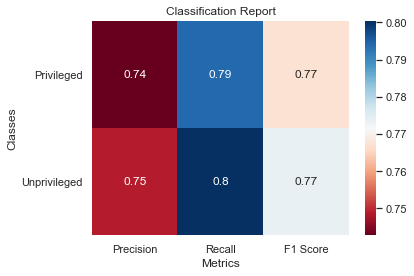

In [7]:
rw_un_metrics = classify(
    make_pipeline(
        StandardScaler(),
        LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_unbias_data, privileged_group, unprivileged_group, debiaser=rw)

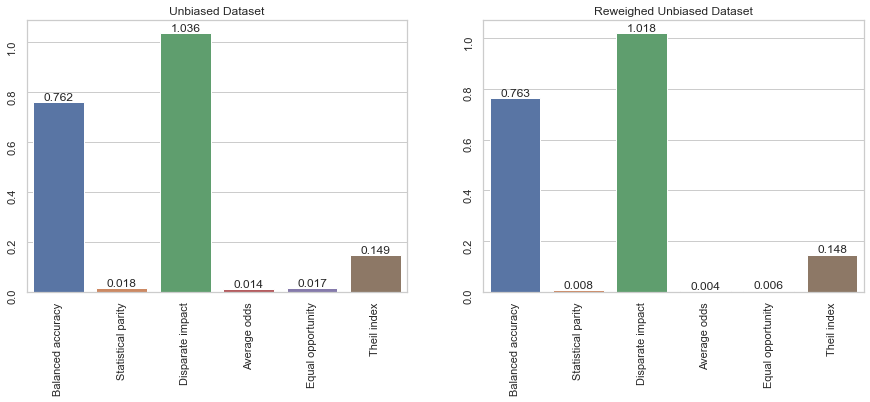

In [8]:
plot_metrics_comparison(class_metrics, rw_un_metrics, "Unbiased Dataset", "Reweighed Unbiased Dataset")
plt.show()

## Disparate Impact Remover

Here we apply the _Disparate Impact Remover_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [9]:
dir_unb_data = bin_data.copy()
scaler = MinMaxScaler(copy=False)
dir_unb_data.features = scaler.fit_transform(dir_unb_data.features)

In [10]:
di = DisparateImpactRemover(sensitive_attribute='s')

### Classification metrics

### Dataset Metrics:

Disparate Impact: 1.0162
Statistical Parity: 0.0080




### Classification Metrics:

Balanced accuracy: 0.7658
Statistical parity: -0.0016
Disparate impact: 0.9988
Average odds: -0.0063
Equal opportunity: -0.0084
Theil index: 0.1352


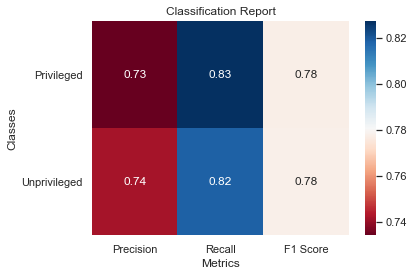

In [11]:
dir_fair_metrics = classify(
    make_pipeline(StandardScaler(),
                  LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_unb_data, privileged_group, unprivileged_group, sensitive_attributes=['s'], debiaser=di)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


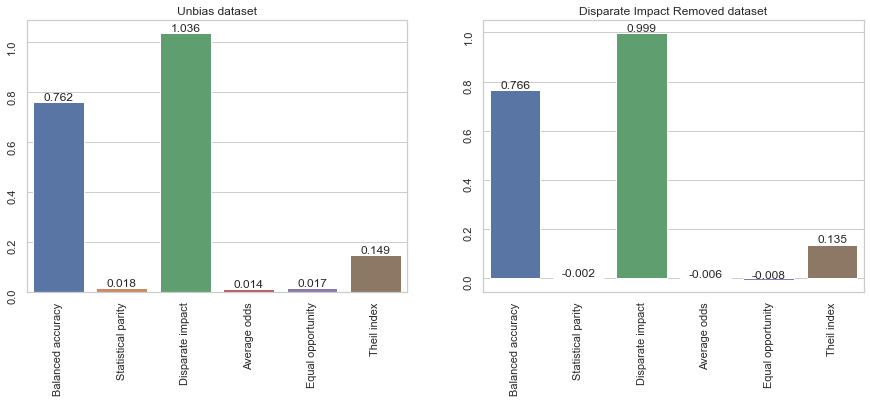

In [12]:
plot_metrics_comparison(class_metrics, dir_fair_metrics, "Unbias dataset", "Disparate Impact Removed dataset")
plt.show()

## Modified Reweighing (Sampling)

In [13]:
unb_sample_ds = bin_data.copy()
sampler = Sampler(round_level=3)

### Classification Metrics

### Dataset Metrics:

Disparate Impact: 1.0007
Statistical Parity: 0.0004




### Classification Metrics:

Balanced accuracy: 0.7630
Statistical parity: 0.0095
Disparate impact: 1.0215
Average odds: 0.0052
Equal opportunity: 0.0078
Theil index: 0.1481


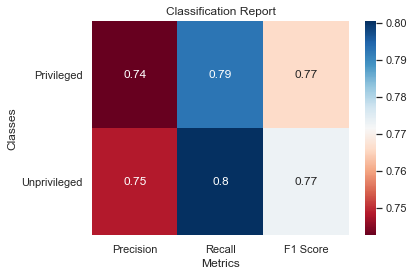

In [14]:
unb_sample_metrics = classify(
    make_pipeline(StandardScaler(),
                  LogisticRegression(class_weight='balanced', solver='liblinear')), 
                  unb_sample_ds, privileged_group, unprivileged_group, debiaser=sampler)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


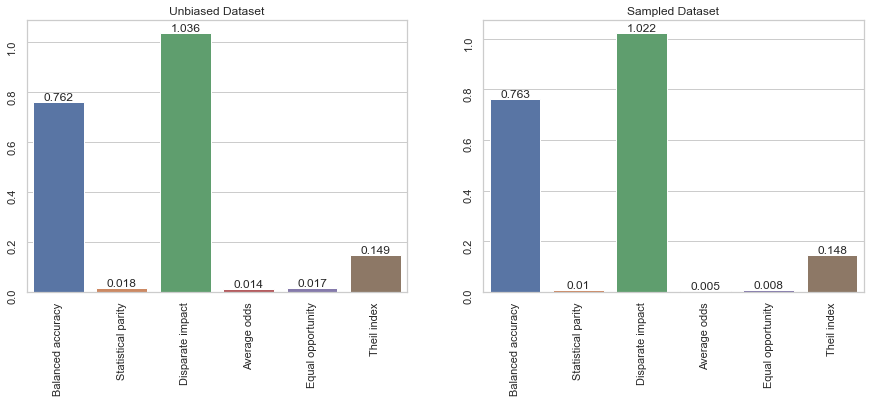

In [15]:
plot_metrics_comparison(class_metrics, unb_sample_metrics, 'Unbiased Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In the following we compare the performances of _Reweighing_ and _Disparate Impact Remover_ on the unbias dataset. 

In [16]:
un_merged_metrics = merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Sampled Dataset': unb_sample_metrics,
    'Disparate Impact Removed': dir_fair_metrics
})

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Disparate Impact Removed,-0.0063,0.7658,0.9988,-0.0084,-0.0016,0.1352
Reweighed,0.0038,0.7632,1.0179,0.0061,0.0082,0.1479
Sampled Dataset,0.0052,0.7630,1.0215,0.0078,0.0095,0.1481
Unbias Data,0.0135,0.7621,1.0362,0.0167,0.0181,0.1489


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


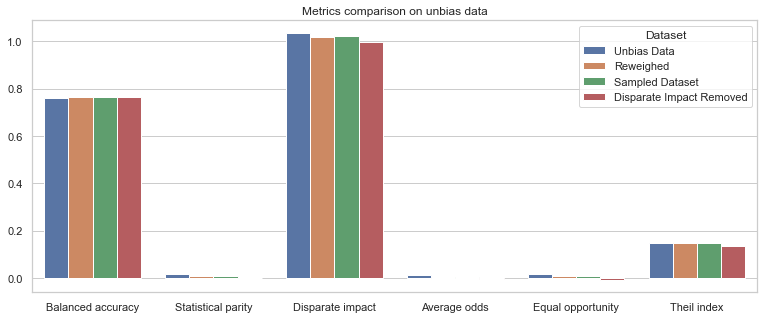

In [17]:
plot_syntesis(un_merged_metrics, 'Metrics comparison on unbias data')
plt.savefig('imgs/synthetic/syntesis_unb.pdf')
plt.show()

# Unbalanced Bias dataset

Let's change the previous dataset adding a bias on the sensitive attribute `s` with value 0 and keeping the instances with `s=1` invariate:

In [18]:
bias_data = data.copy()
bias_data.loc[(bias_data['s'] == 0) & (bias_data.index < int(len(data)/2)) , '10'] = 0.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


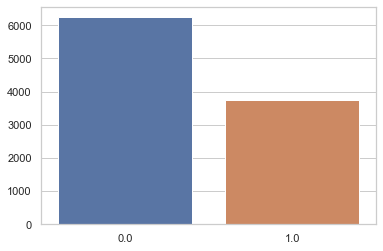

In [19]:
sns.barplot(x=bias_data['10'].value_counts().index, y=bias_data['10'].value_counts().values)
plt.savefig(os.path.join(path, 'unb_label_count.pdf'))
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


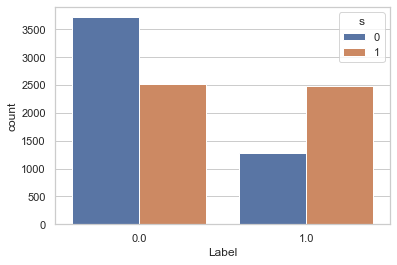

In [20]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=bias_data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.savefig(os.path.join(path, 'unb_bias.pdf'))
plt.show()

Let's compute the dataset fairness metrics on this new dataset:

In [21]:
bias_data_bin = BinaryLabelDataset(df = bias_data, label_names=['10'], protected_attribute_names=['s'])

### Dataset Metrics:

Disparate Impact: 0.5173
Statistical Parity: -0.2392




### Classification Metrics:

Balanced accuracy: 0.7261
Statistical parity: -0.3984
Disparate impact: 0.3983
Average odds: -0.3551
Equal opportunity: -0.5179
Theil index: 0.1501


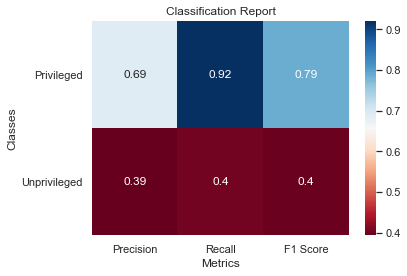

In [22]:
bias_class_metrics = classify(
    make_pipeline(StandardScaler(), 
                  LogisticRegression(class_weight='balanced', solver='liblinear')), 
                  bias_data_bin, privileged_group, unprivileged_group)

##  Reweighing

In [23]:
rw_data = bias_data_bin.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.7125
Statistical parity: -0.0672
Disparate impact: 0.8777
Average odds: 0.0079
Equal opportunity: -0.0932
Theil index: 0.1445


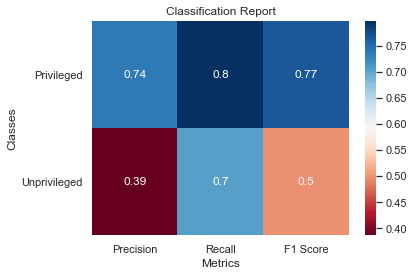

In [24]:
rw_class_metrics = classify(make_pipeline(StandardScaler(), 
                                          LogisticRegression(class_weight='balanced', solver='liblinear')), 
                            rw_data, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


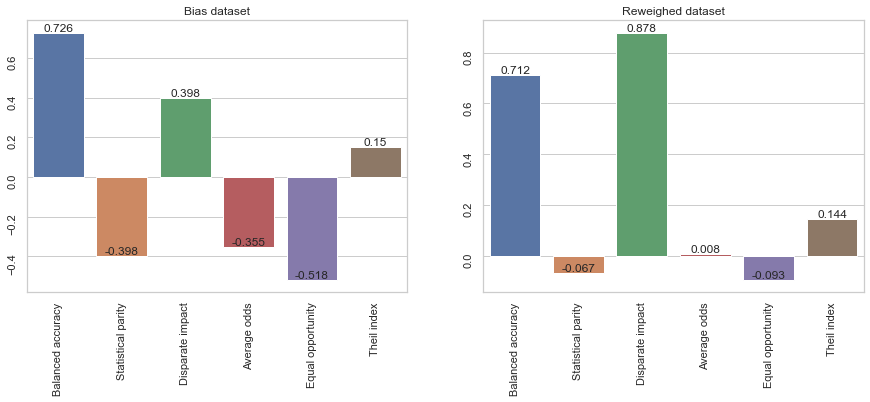

In [25]:
plot_metrics_comparison(bias_class_metrics, rw_class_metrics, "Bias dataset", "Reweighed dataset")
plt.show()

## Disparate Impact Remover

In [26]:
dir_data = bias_data_bin.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


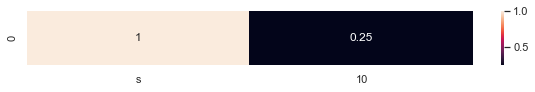

In [27]:
plot_correlation(dir_data, 's')
plt.show()

In [28]:
dr = DisparateImpactRemover(sensitive_attribute='s')
#dir_data = dr.fit_transform(dir_data)

### Dataset Metrics:

Disparate Impact: 0.5174
Statistical Parity: -0.2392




### Classification Metrics:

Balanced accuracy: 0.7089
Statistical parity: -0.0003
Disparate impact: 1.0001
Average odds: 0.0830
Equal opportunity: 0.0001
Theil index: 0.1385


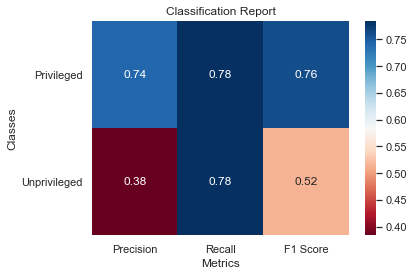

In [29]:
dir_class_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced',solver='liblinear')), 
    dir_data, privileged_group, unprivileged_group,sensitive_attributes=['s'], debiaser=dr)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


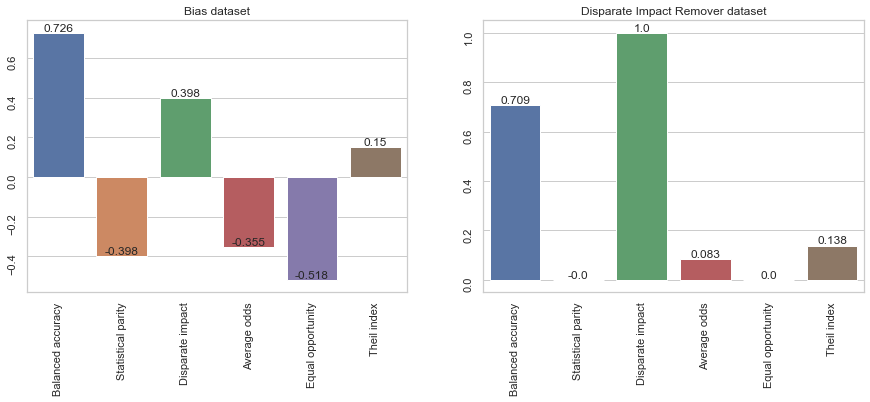

In [30]:
plot_metrics_comparison(bias_class_metrics, dir_class_metrics, "Bias dataset", "Disparate Impact Remover dataset")
plt.show()

## Modified Reweighing (Sampling)

In [31]:
sampled_bias_data = bias_data_bin.copy()
sampler = Sampler(round_level=2)

### Dataset Metrics:

Disparate Impact: 0.9882
Statistical Parity: -0.0045




### Classification Metrics:

Balanced accuracy: 0.7141
Statistical parity: -0.0691
Disparate impact: 0.8740
Average odds: 0.0084
Equal opportunity: -0.0906
Theil index: 0.1427


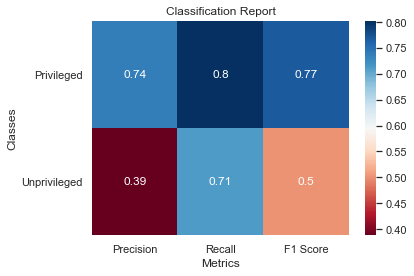

In [32]:
sample_bias_metrics = classify(make_pipeline(StandardScaler(), 
                                             LogisticRegression(class_weight='balanced', solver='liblinear')), 
                               sampled_bias_data, privileged_group, unprivileged_group, debiaser=sampler)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


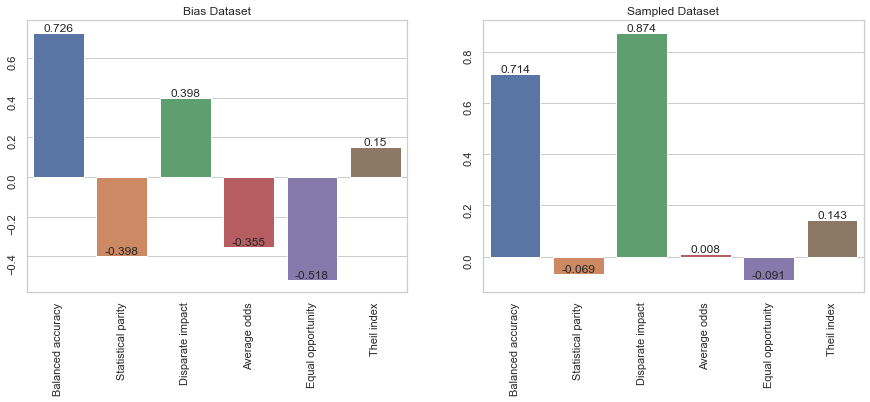

In [33]:
plot_metrics_comparison(bias_class_metrics, sample_bias_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In [34]:
unbal_merged_metrics = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Sampled Dataset': sample_bias_metrics,
    'Disparate Impact Removed': dir_class_metrics
})

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias unbalanced data,-0.3551,0.7261,0.3983,-0.5179,-0.3984,0.1501
Disparate Impact Removed,0.0830,0.7089,1.0001,0.0001,-0.0003,0.1385
Reweighed,0.0079,0.7125,0.8777,-0.0932,-0.0672,0.1445
Sampled Dataset,0.0084,0.7141,0.8740,-0.0906,-0.0691,0.1427


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


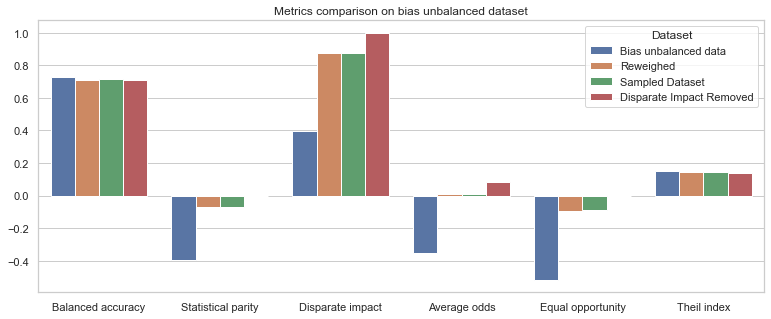

In [35]:
plot_syntesis(unbal_merged_metrics, 'Metrics comparison on bias unbalanced dataset')
plt.savefig(os.path.join(path,'unb_synt.pdf'))
plt.show()

# Bias balanced dataset

Let's balance the previous dataset changing the labels of half of the samples with `s=1` to `1.0`

In [36]:
bias_bal_data = bias_data.copy()
bias_bal_data.loc[(bias_data['s'] == 1) & (bias_data.index < int(len(data)/2)) & (bias_data['10']==0.0) , '10'] = 1.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


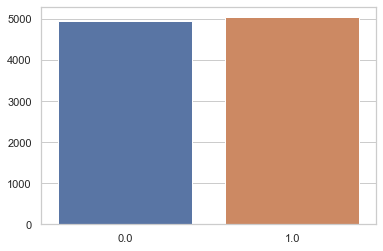

In [37]:
sns.barplot(x=bias_bal_data['10'].value_counts().index, y=bias_bal_data['10'].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


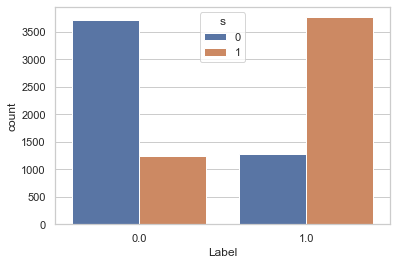

In [38]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=bias_bal_data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

In [39]:
bias_bal_bin = BinaryLabelDataset(df=bias_bal_data, label_names=['10'], protected_attribute_names=['s'])

### Dataset Metrics:

Disparate Impact: 0.3406
Statistical Parity: -0.4964




### Classification Metrics:

Balanced accuracy: 0.7414
Statistical parity: -0.8850
Disparate impact: 0.0428
Average odds: -0.8557
Equal opportunity: -0.8883
Theil index: 0.1903


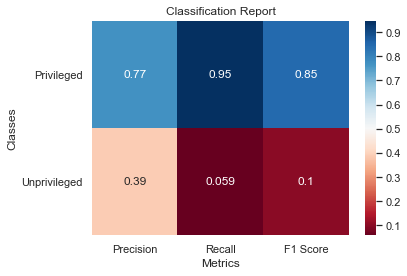

In [40]:
bias_bal_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    bias_bal_bin, privileged_group, unprivileged_group)

## Reweighing

In [41]:
rw_bal = bias_bal_bin.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.6620
Statistical parity: -0.1375
Disparate impact: 0.7758
Average odds: 0.0307
Equal opportunity: 0.0240
Theil index: 0.2145


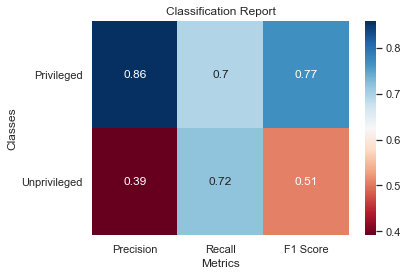

In [42]:
rw_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_bal, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


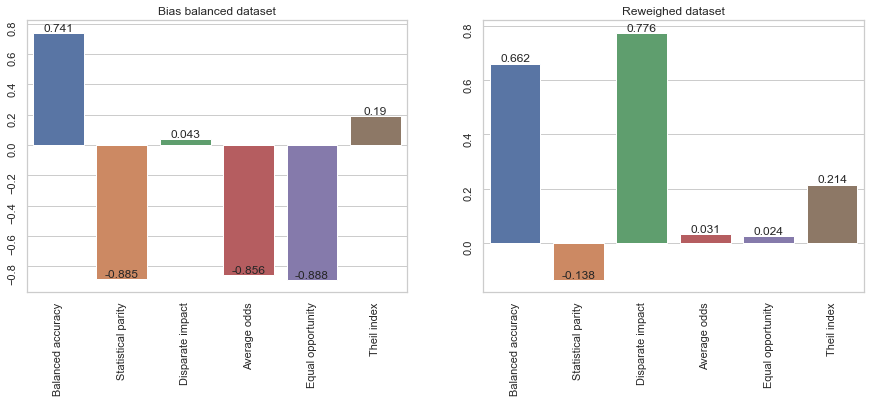

In [43]:
plot_metrics_comparison(bias_bal_metrics, rw_metrics, 'Bias balanced dataset', 'Reweighed dataset')
plt.show()

## Modified Reweighing (Sampling)

In [44]:
bias_sample_ds = bias_bal_bin.copy()
sampler = Sampler(round_level=3)

### Dataset Metrics:

Disparate Impact: 0.9994
Statistical Parity: -0.0003




### Classification Metrics:

Balanced accuracy: 0.6629
Statistical parity: -0.1446
Disparate impact: 0.7635
Average odds: 0.0229
Equal opportunity: 0.0121
Theil index: 0.2159


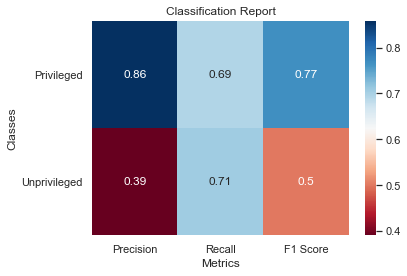

In [45]:
sampling_metrics = classify(make_pipeline(
    StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                            bias_sample_ds, privileged_group, unprivileged_group, debiaser=sampler)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


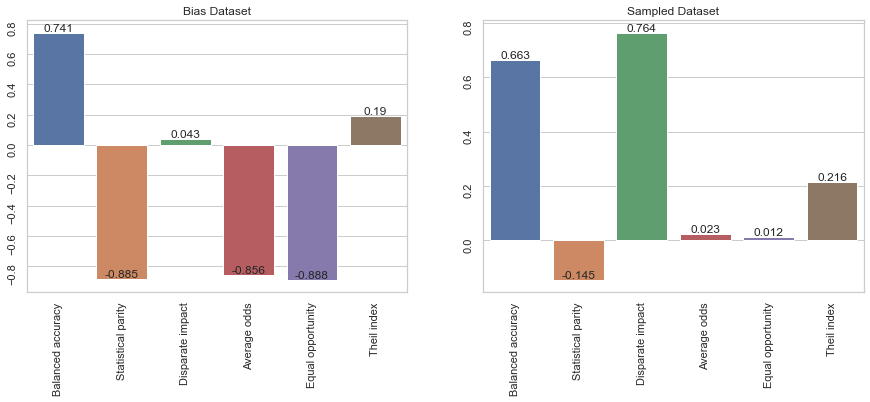

In [46]:
plot_metrics_comparison(bias_bal_metrics, sampling_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Disparate Impact Remover

In [47]:
dir_bal = bias_bal_bin.copy()
scaler = MinMaxScaler()
dir_bal.features = scaler.fit_transform(dir_bal.features)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


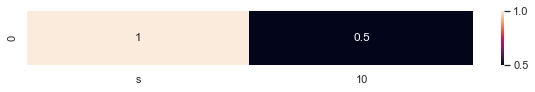

In [48]:
plot_correlation(dir_bal, 's')
plt.show()

In [49]:
dr = DisparateImpactRemover(sensitive_attribute='s')
#dir_bal = dr.fit_transform(dir_bal)

### Dataset Metrics:

Disparate Impact: 0.3406
Statistical Parity: -0.4964




### Classification Metrics:

Balanced accuracy: 0.6310
Statistical parity: 0.0002
Disparate impact: 1.0007
Average odds: 0.1733
Equal opportunity: 0.1803
Theil index: 0.2175


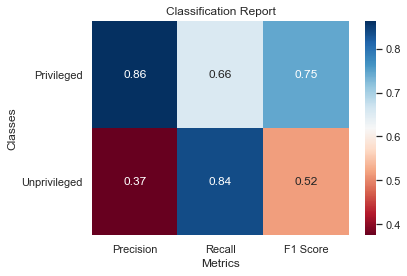

In [50]:
dir_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_bal, privileged_group, unprivileged_group, sensitive_attributes=['s'], debiaser=dr)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


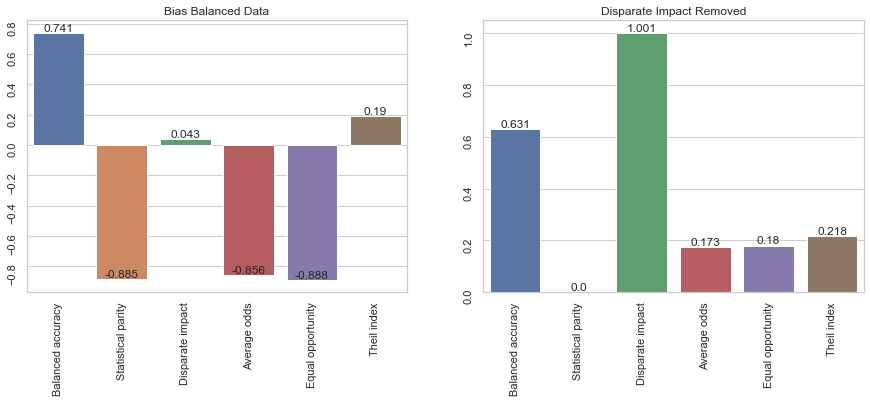

In [51]:
plot_metrics_comparison(bias_bal_metrics, dir_score, 'Bias Balanced Data', 'Disparate Impact Removed')
plt.show()

## Reweighing vs Disparate Impact Remover vs Sampling

In [52]:
bal_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Sampled Dataset': sampling_metrics,
    'Disparate Impact Removed': dir_score
})

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Balanced Data,-0.8557,0.7414,0.0428,-0.8883,-0.8850,0.1903
Disparate Impact Removed,0.1733,0.6310,1.0007,0.1803,0.0002,0.2175
Reweighed,0.0307,0.6620,0.7758,0.0240,-0.1375,0.2145
Sampled Dataset,0.0229,0.6629,0.7635,0.0121,-0.1446,0.2159


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


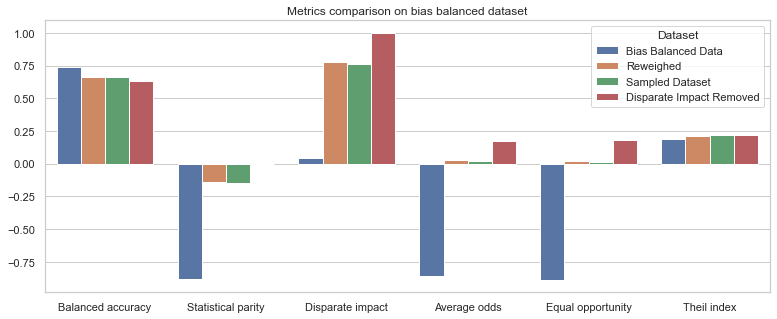

In [53]:
plot_syntesis(bal_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()

# Comparison of the three datasets

Here we compare the metrics for the three versions of the dataset and the methods applied:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


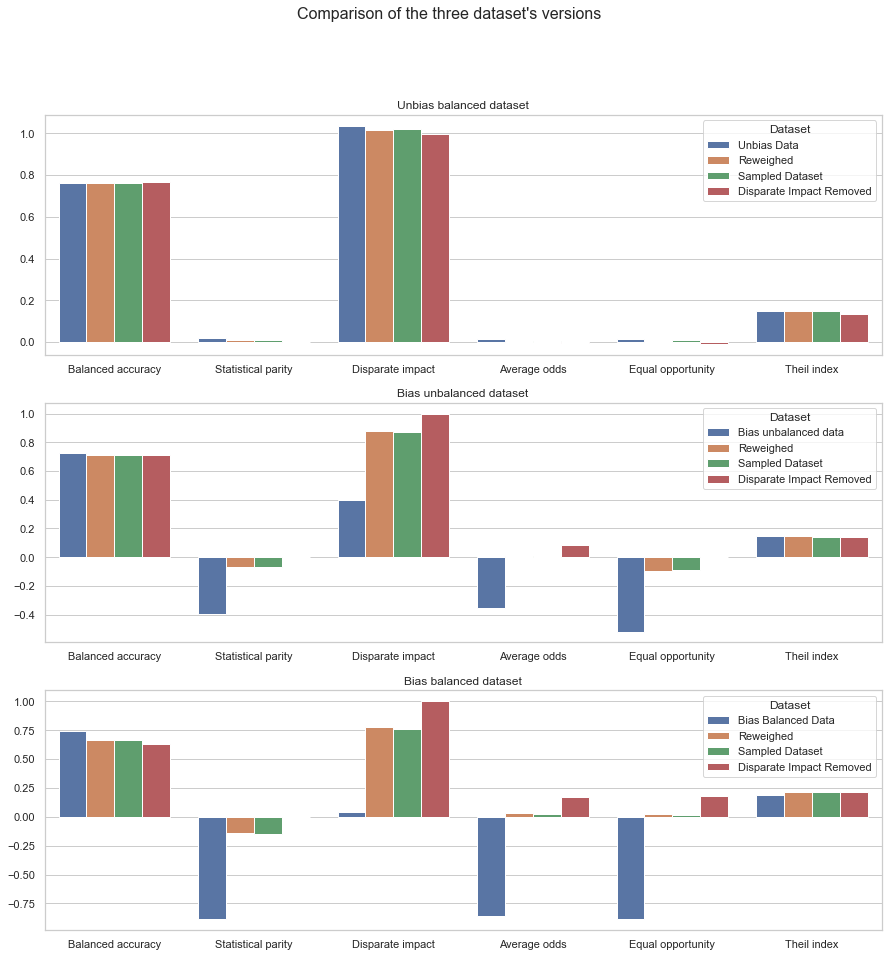

In [54]:
fig, axes = plt.subplots(3,1,figsize=(15,15))
sns.barplot(data=un_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[0],)
sns.barplot(data=unbal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[1])
sns.barplot(data=bal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[2])
for ax in axes:
    ax.set(xlabel='', ylabel='')
axes[0].set_title('Unbias balanced dataset')
axes[1].set_title('Bias unbalanced dataset')
axes[2].set_title('Bias balanced dataset')
fig.suptitle("Comparison of the three dataset's versions", fontsize=16)
plt.show()

# Combine Reweighing and DIR

As can be seen from the charts above both RW and DIR performs well in mitigating the unfairness of the classifier. However both have some lacks:

1. Reweighing requires that a classifier takes account of instance weights, but not all the classifier models do so
2. Disparate Impact Remover has no effect on the dataset fairness metrics but only on the classifier metrics

To solve these problems we will now try to combine these two algorithms by applying the instance weights to the DIR modified dataset and see the results.

## Test with unbias data

In [55]:
un_rw_dir = dir_unb_data.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
un_rw_dir = rw.fit_transform(un_rw_dir)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.7622
Statistical parity: -0.0068
Disparate impact: 0.9891
Average odds: -0.0067
Equal opportunity: -0.0059
Theil index: 0.1483


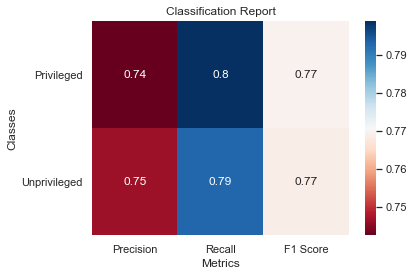

In [56]:
unb_rw_dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                            un_rw_dir, privileged_group, unprivileged_group, sensitive_attributes=['s'])

### Comparison

In [57]:
un_rw_dir_merg =  merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Disparate Impact Removed': dir_fair_metrics,
    'Sampling': unb_sample_metrics,
    'RW + DIR': unb_rw_dir_score
})

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Disparate Impact Removed,-0.0063,0.7658,0.9988,-0.0084,-0.0016,0.1352
RW + DIR,-0.0067,0.7622,0.9891,-0.0059,-0.0068,0.1483
Reweighed,0.0038,0.7632,1.0179,0.0061,0.0082,0.1479
Sampling,0.0052,0.7630,1.0215,0.0078,0.0095,0.1481
Unbias Data,0.0135,0.7621,1.0362,0.0167,0.0181,0.1489


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


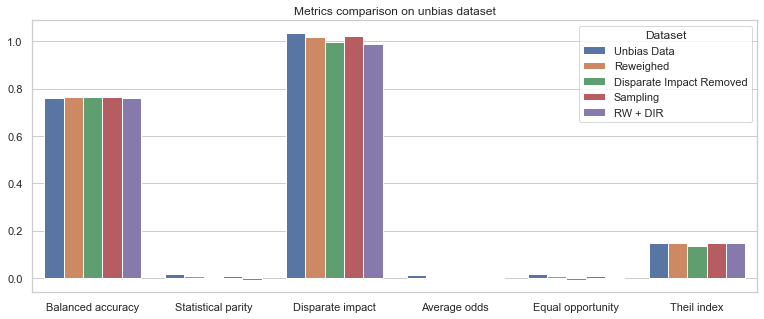

In [58]:
plot_syntesis(un_rw_dir_merg, 'Metrics comparison on unbias dataset')
plt.show()

## Test with unbalance bias data

In [59]:
unbal_dir_rw_data = dir_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
unbal_dir_rw_data = rw.fit_transform(unbal_dir_rw_data)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7153
Statistical parity: 0.0982
Disparate impact: 1.2272
Average odds: 0.0781
Equal opportunity: -0.0021
Theil index: 0.1466


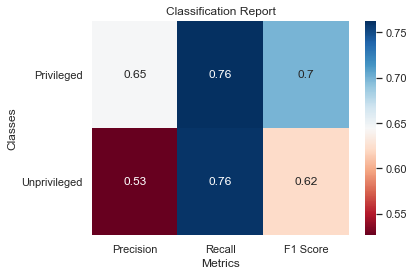

In [60]:
rw_dir_score = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                            unbal_dir_rw_data, privileged_group, unprivileged_group, sensitive_attributes=['s'])

In [61]:
unbal_rw_dir_score = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Disparate Impact Removed': dir_class_metrics,
    'Sampling': sample_bias_metrics,
    'RW + DIR': rw_dir_score
})

### Comparison

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias unbalanced data,-0.3551,0.7261,0.3983,-0.5179,-0.3984,0.1501
Disparate Impact Removed,0.0830,0.7089,1.0001,0.0001,-0.0003,0.1385
RW + DIR,0.0781,0.7153,1.2272,-0.0021,0.0982,0.1466
Reweighed,0.0079,0.7125,0.8777,-0.0932,-0.0672,0.1445
Sampling,0.0084,0.7141,0.8740,-0.0906,-0.0691,0.1427


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


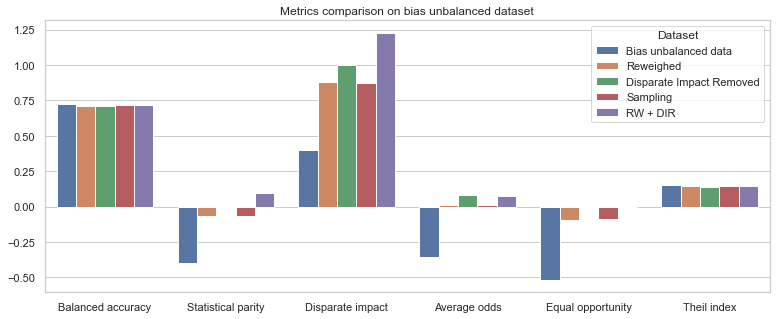

In [62]:
plot_syntesis(unbal_rw_dir_score, 'Metrics comparison on bias unbalanced dataset')
plt.savefig(os.path.join(path, 'rw_dir_syn.pdf'))
plt.show()

## Test with balanced bias data

In [63]:
dir_rw_data = dir_bal.copy()
rw = Reweighing(unprivileged_group, privileged_group)
dir_rw_data = rw.fit_transform(dir_rw_data)

In [64]:
score = compute_dataset_fairness_metrics(dir_rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.6752
Statistical parity: 0.1704
Disparate impact: 1.3787
Average odds: 0.1705
Equal opportunity: 0.1750
Theil index: 0.2327


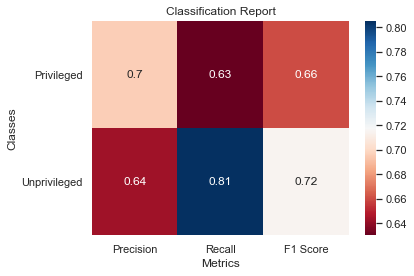

In [65]:
rw_dir_score = classify(make_pipeline(StandardScaler(),LogisticRegression(class_weight='balanced', solver='liblinear')),
                        dir_rw_data, privileged_group, unprivileged_group, sensitive_attributes=['s'])

In [66]:
rw_dir_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Disparate Impact Removed': dir_score,
    'Sampling': sampling_metrics,
    'RW + DIR': rw_dir_score
})

### Comparison

metrics,Average odds,Balanced accuracy,Disparate impact,Equal opportunity,Statistical parity,Theil index
Dataset,,,,,,
Bias Balanced Data,-0.8557,0.7414,0.0428,-0.8883,-0.8850,0.1903
Disparate Impact Removed,0.1733,0.6310,1.0007,0.1803,0.0002,0.2175
RW + DIR,0.1705,0.6752,1.3787,0.1750,0.1704,0.2327
Reweighed,0.0307,0.6620,0.7758,0.0240,-0.1375,0.2145
Sampling,0.0229,0.6629,0.7635,0.0121,-0.1446,0.2159


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


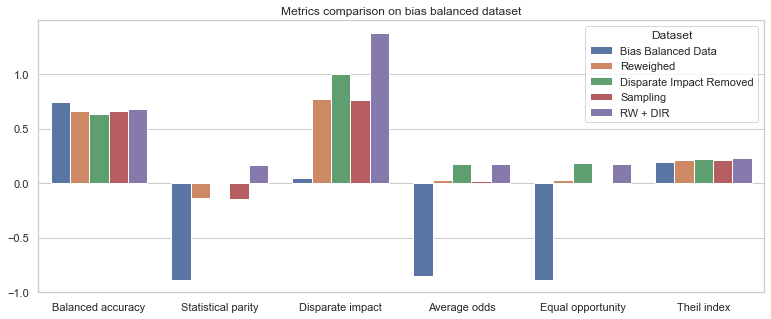

In [67]:
plot_syntesis(rw_dir_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()